In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [2]:
# Load the dataset
data = pd.read_csv(r'D:\ML Repositories\Price_forecasting_project\data\raw\processed\Pulwama\Prichoo\Delicious_A_dataset.csv')

In [3]:
data

,Date,District,Market,Fruit,Variety,Grade,Min Price (per kg),Max Price (per kg),Avg Price (per kg),Mask
0,2018-09-01,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.000,0
1,2018-09-02,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.000,0
2,2018-09-03,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.000,0
3,2018-09-04,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.000,0
4,2018-09-05,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.000,0
...,...,...,...,...,...,...,...,...,...,...
2293,2024-12-11,Pulwama,Prichoo,Apple,Delicious,A,75.0,81.25,78.125,1
2294,2024-12-12,Pulwama,Prichoo,Apple,Delicious,A,75.0,81.25,78.125,1
2295,2024-12-13,Pulwama,Prichoo,Apple,Delicious,A,75.0,81.25,78.125,1
2296,2024-12-14,Pulwama,Prichoo,Apple,Delicious,A,75.0,81.25,78.125,1


In [4]:
data.columns

Index(['Date', 'District', 'Market', 'Fruit', 'Variety', 'Grade',
       'Min Price (per kg)', 'Max Price (per kg)', 'Avg Price (per kg)',
       'Mask'],
      dtype='object')

In [5]:
# Ensure proper datetime format for models requiring 'ds'
data = data.rename(columns={"Date": "ds", "Avg Price (per kg)": "y"})
data['ds'] = pd.to_datetime(data['ds'])

In [6]:
# Filter for available data (Mask=1) for SARIMA and Prophet
available_data = data[data['Mask'] == 1].copy()

In [7]:
available_data.reset_index(inplace=True)

In [8]:
# Split data for training and testing
train_data = available_data[available_data['ds'] < '2024-09-15']
test_data = available_data[available_data['ds'] >= '2024-09-15']

<Axes: >

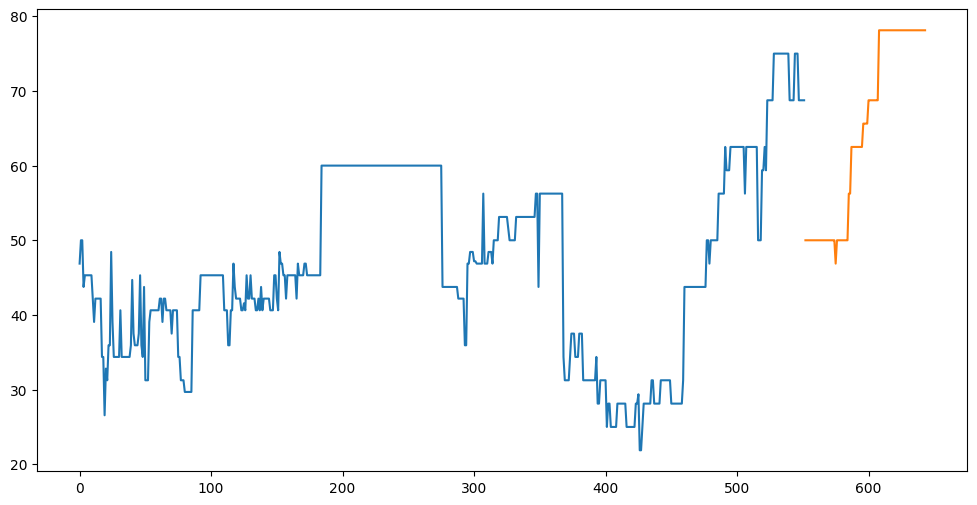

In [9]:
plt.figure(figsize=(12,6))
train_data['y'].plot()
test_data['y'].plot()

In [10]:
# Create a function to reverse scaling
def reverse_scaling(scaled_values, data):
    return scaled_values * (data['y'].max() - data['y'].min()) + data['y'].min()

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

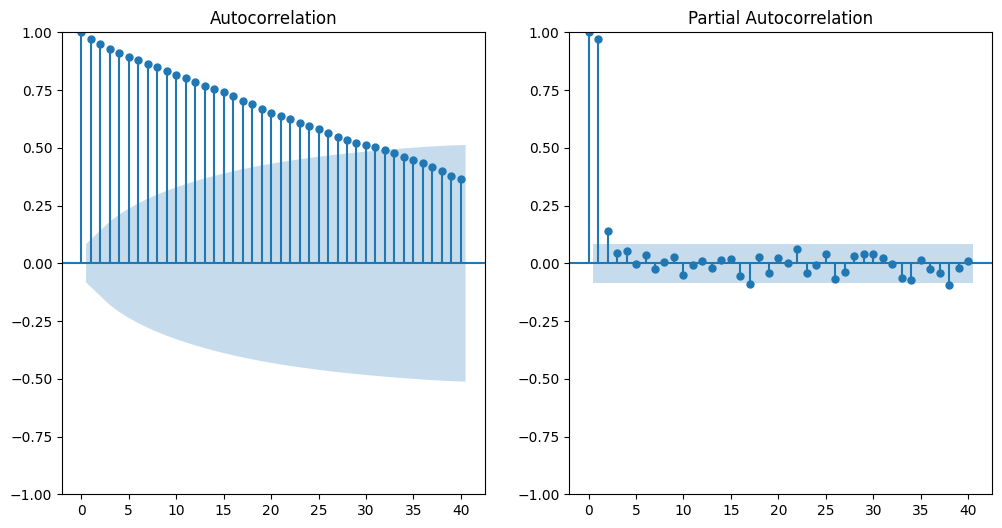

In [12]:
# Plot ACF and PACF for the given time series
plt.figure(figsize=(12, 6))

# ACF Plot
plt.subplot(1, 2, 1)
plot_acf(train_data['y'], lags=40, ax=plt.gca())

# PACF Plot
plt.subplot(1, 2, 2)
plot_pacf(train_data['y'], lags=40, ax=plt.gca())

plt.show()


In [14]:
import itertools

# Define the range of parameters for grid search
p_values = range(0, 3)  # AR terms
d_values = range(0, 2)  # Differencing terms
q_values = range(0, 3)  # MA terms
P_values = range(0, 3)  # Seasonal AR terms
D_values = range(0, 2)  # Seasonal differencing terms
Q_values = range(0, 3)  # Seasonal MA terms
seasonal_periods = [12]  # Seasonal period (e.g., 12 for monthly data with yearly seasonality)

# Prepare parameter combinations
param_grid = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, seasonal_periods))

# Initialize a list to store results
results = []

# Check if the dataset has missing values
if train_data['y'].isnull().sum() > 0:
    print("Warning: The dataset contains missing values. Consider imputing or removing them.")
else:
    print("No missing values detected in the data.")

# Loop through all parameter combinations
for param in param_grid:
    try:
        # Unpack the parameters
        p, d, q, P, D, Q, S = param

        # Define and fit the SARIMA model with the current parameters
        sarima_model = SARIMAX(train_data['y'],
                               order=(p, d, q),             # (p, d, q)
                               seasonal_order=(P, D, Q, S),  # (P, D, Q, S)
                               enforce_stationarity=False,   # Avoid stationarity constraint for SARIMA
                               enforce_invertibility=False)  # Avoid invertibility constraint for SARIMA
        
        # Fit the model
        sarima_results = sarima_model.fit(disp=False)

        # Store the model parameters and AIC
        results.append((param, sarima_results.aic))
        print(f"Successfully fitted model with parameters {param}. AIC: {sarima_results.aic}")

    except Exception as e:
        print(f"Error fitting model with parameters {param}: {e}")
        continue

# Check if any results were generated
if results:
    # Convert the results into a DataFrame
    results_df = pd.DataFrame(results, columns=["Params", "AIC"])

    # Sort by AIC and display the best parameters
    best_params = results_df.sort_values(by="AIC").iloc[0]
    print("\nBest Parameters:", best_params)
else:
    print("No valid SARIMA models were successfully fitted. Please review your data and parameter ranges.")


No missing values detected in the data.
Successfully fitted model with parameters (0, 0, 0, 0, 0, 0, 12). AIC: 5843.064511937105
Successfully fitted model with parameters (0, 0, 0, 0, 0, 1, 12). AIC: 5093.6759854989705
Successfully fitted model with parameters (0, 0, 0, 0, 0, 2, 12). AIC: 4599.903010922193
Successfully fitted model with parameters (0, 0, 0, 0, 1, 0, 12). AIC: 3684.6314779189433
Successfully fitted model with parameters (0, 0, 0, 0, 1, 1, 12). AIC: 3588.894015202748
Successfully fitted model with parameters (0, 0, 0, 0, 1, 2, 12). AIC: 3507.364116208358
Successfully fitted model with parameters (0, 0, 0, 1, 0, 0, 12). AIC: 3692.760051925388
Successfully fitted model with parameters (0, 0, 0, 1, 0, 1, 12). AIC: 3681.6166886301025
Successfully fitted model with parameters (0, 0, 0, 1, 0, 2, 12). AIC: 3588.8522396350127
Successfully fitted model with parameters (0, 0, 0, 1, 1, 0, 12). AIC: 3594.692920810511
Successfully fitted model with parameters (0, 0, 0, 1, 1, 1, 12). 

c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (0, 0, 1, 0, 0, 1, 12). AIC: 4471.259338704067
Successfully fitted model with parameters (0, 0, 1, 0, 0, 2, 12). AIC: 4054.0328188231306
Successfully fitted model with parameters (0, 0, 1, 0, 1, 0, 12). AIC: 3336.9176856618083
Successfully fitted model with parameters (0, 0, 1, 0, 1, 1, 12). AIC: 3221.0713824757017
Successfully fitted model with parameters (0, 0, 1, 0, 1, 2, 12). AIC: 3133.657623412156
Successfully fitted model with parameters (0, 0, 1, 1, 0, 0, 12). AIC: 3351.1530939720506
Successfully fitted model with parameters (0, 0, 1, 1, 0, 1, 12). AIC: 3312.241640556501
Successfully fitted model with parameters (0, 0, 1, 1, 0, 2, 12). AIC: 3229.872091953417
Successfully fitted model with parameters (0, 0, 1, 1, 1, 0, 12). AIC: 3232.744102438216
Successfully fitted model with parameters (0, 0, 1, 1, 1, 1, 12). AIC: 3218.166883146182
Successfully fitted model with parameters (0, 0, 1, 1, 1, 2, 12). AIC: 3135.304735601435
Successfully fitt

c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (0, 0, 1, 2, 0, 1, 12). AIC: 3233.1918505142685
Successfully fitted model with parameters (0, 0, 1, 2, 0, 2, 12). AIC: 3221.2254577901695
Successfully fitted model with parameters (0, 0, 1, 2, 1, 0, 12). AIC: 3149.620084117114
Successfully fitted model with parameters (0, 0, 1, 2, 1, 1, 12). AIC: 3150.6865444052337
Successfully fitted model with parameters (0, 0, 1, 2, 1, 2, 12). AIC: 3133.3962258659503
Successfully fitted model with parameters (0, 0, 2, 0, 0, 0, 12). AIC: 4557.499397950074


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (0, 0, 2, 0, 0, 1, 12). AIC: 4472.363114905558
Successfully fitted model with parameters (0, 0, 2, 0, 0, 2, 12). AIC: 3739.8629584804166
Successfully fitted model with parameters (0, 0, 2, 0, 1, 0, 12). AIC: 3165.097306675538
Successfully fitted model with parameters (0, 0, 2, 0, 1, 1, 12). AIC: 3038.8450971588954
Successfully fitted model with parameters (0, 0, 2, 0, 1, 2, 12). AIC: 2966.5200780382042
Successfully fitted model with parameters (0, 0, 2, 1, 0, 0, 12). AIC: 3183.32347223074
Successfully fitted model with parameters (0, 0, 2, 1, 0, 1, 12). AIC: 3118.8752298504733
Successfully fitted model with parameters (0, 0, 2, 1, 0, 2, 12). AIC: 3142.164366394909
Successfully fitted model with parameters (0, 0, 2, 1, 1, 0, 12). AIC: 3061.457288293219
Successfully fitted model with parameters (0, 0, 2, 1, 1, 1, 12). AIC: 3043.0507947721444
Successfully fitted model with parameters (0, 0, 2, 1, 1, 2, 12). AIC: 2967.9295657532493
Successfully fit

c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (1, 0, 0, 0, 1, 1, 12). AIC: 2651.8371471485675
Successfully fitted model with parameters (1, 0, 0, 0, 1, 2, 12). AIC: 2576.0970652002607
Successfully fitted model with parameters (1, 0, 0, 1, 0, 0, 12). AIC: 2696.2601535991516
Successfully fitted model with parameters (1, 0, 0, 1, 0, 1, 12). AIC: 2694.5693310047236
Successfully fitted model with parameters (1, 0, 0, 1, 0, 2, 12). AIC: 2606.191497063134
Successfully fitted model with parameters (1, 0, 0, 1, 1, 0, 12). AIC: 2811.8503095536867
Successfully fitted model with parameters (1, 0, 0, 1, 1, 1, 12). AIC: 2653.8367300318096
Successfully fitted model with parameters (1, 0, 0, 1, 1, 2, 12). AIC: 2574.086455827043
Successfully fitted model with parameters (1, 0, 0, 2, 0, 0, 12). AIC: 2609.7948798093375
Successfully fitted model with parameters (1, 0, 0, 2, 0, 1, 12). AIC: 2606.1536513479073


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (1, 0, 0, 2, 0, 2, 12). AIC: 2607.409536919824
Successfully fitted model with parameters (1, 0, 0, 2, 1, 0, 12). AIC: 2683.2523837304298
Successfully fitted model with parameters (1, 0, 0, 2, 1, 1, 12). AIC: 2576.5478790844827
Successfully fitted model with parameters (1, 0, 0, 2, 1, 2, 12). AIC: 2572.692127845621
Successfully fitted model with parameters (1, 0, 1, 0, 0, 0, 12). AIC: 2730.0886340010848
Successfully fitted model with parameters (1, 0, 1, 0, 0, 1, 12). AIC: 2675.985694142917
Successfully fitted model with parameters (1, 0, 1, 0, 0, 2, 12). AIC: 2581.836266013782
Successfully fitted model with parameters (1, 0, 1, 0, 1, 0, 12). AIC: 3021.3102585405018
Successfully fitted model with parameters (1, 0, 1, 0, 1, 1, 12). AIC: 2629.5993889505617
Successfully fitted model with parameters (1, 0, 1, 0, 1, 2, 12). AIC: 2562.941871835134
Successfully fitted model with parameters (1, 0, 1, 1, 0, 0, 12). AIC: 2680.0190592416984
Successfully fi

c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (1, 0, 1, 2, 0, 2, 12). AIC: 2583.8335792649405
Successfully fitted model with parameters (1, 0, 1, 2, 1, 0, 12). AIC: 2674.0577775633597
Successfully fitted model with parameters (1, 0, 1, 2, 1, 1, 12). AIC: 2566.5100850810286
Successfully fitted model with parameters (1, 0, 1, 2, 1, 2, 12). AIC: 2559.3979428791954
Successfully fitted model with parameters (1, 0, 2, 0, 0, 0, 12). AIC: 2726.2862102049235
Successfully fitted model with parameters (1, 0, 2, 0, 0, 1, 12). AIC: 2672.4171194775126
Successfully fitted model with parameters (1, 0, 2, 0, 0, 2, 12). AIC: 2574.527036597825
Successfully fitted model with parameters (1, 0, 2, 0, 1, 0, 12). AIC: 3018.206461382039
Successfully fitted model with parameters (1, 0, 2, 0, 1, 1, 12). AIC: 2624.030189331795
Successfully fitted model with parameters (1, 0, 2, 0, 1, 2, 12). AIC: 2559.320085807757
Successfully fitted model with parameters (1, 0, 2, 1, 0, 0, 12). AIC: 2680.4416800360505


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (1, 0, 2, 1, 0, 1, 12). AIC: 2669.401732568984


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (1, 0, 2, 1, 0, 2, 12). AIC: 2573.6521065752686
Successfully fitted model with parameters (1, 0, 2, 1, 1, 0, 12). AIC: 2806.4933339104955
Successfully fitted model with parameters (1, 0, 2, 1, 1, 1, 12). AIC: 2626.0301551664083
Successfully fitted model with parameters (1, 0, 2, 1, 1, 2, 12). AIC: 2557.1612622131793
Successfully fitted model with parameters (1, 0, 2, 2, 0, 0, 12). AIC: 2598.0780222015874
Successfully fitted model with parameters (1, 0, 2, 2, 0, 1, 12). AIC: 2594.4524545622135


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (1, 0, 2, 2, 0, 2, 12). AIC: 2572.5766583590225
Successfully fitted model with parameters (1, 0, 2, 2, 1, 0, 12). AIC: 2675.279823330212
Successfully fitted model with parameters (1, 0, 2, 2, 1, 1, 12). AIC: 2566.5502487566305
Successfully fitted model with parameters (1, 0, 2, 2, 1, 2, 12). AIC: 2555.022738094979
Successfully fitted model with parameters (1, 1, 0, 0, 0, 0, 12). AIC: 2730.291666430283
Successfully fitted model with parameters (1, 1, 0, 0, 0, 1, 12). AIC: 2676.0727527801905
Successfully fitted model with parameters (1, 1, 0, 0, 0, 2, 12). AIC: 2584.2720519601994
Successfully fitted model with parameters (1, 1, 0, 0, 1, 0, 12). AIC: 3055.267242897203
Successfully fitted model with parameters (1, 1, 0, 0, 1, 1, 12). AIC: 2633.177312616582
Successfully fitted model with parameters (1, 1, 0, 0, 1, 2, 12). AIC: 2563.594176381801
Successfully fitted model with parameters (1, 1, 0, 1, 0, 0, 12). AIC: 2676.1654825416113
Successfully fit

c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (1, 1, 2, 2, 1, 1, 12). AIC: 2558.44731320992
Successfully fitted model with parameters (1, 1, 2, 2, 1, 2, 12). AIC: 2552.090345729486
Successfully fitted model with parameters (2, 0, 0, 0, 0, 0, 12). AIC: 2732.255076460084
Successfully fitted model with parameters (2, 0, 0, 0, 0, 1, 12). AIC: 2682.0694824482384
Successfully fitted model with parameters (2, 0, 0, 0, 0, 2, 12). AIC: 2597.2279529319103
Successfully fitted model with parameters (2, 0, 0, 0, 1, 0, 12). AIC: 3021.1313619355733
Successfully fitted model with parameters (2, 0, 0, 0, 1, 1, 12). AIC: 2639.806272332744
Successfully fitted model with parameters (2, 0, 0, 0, 1, 2, 12). AIC: 2567.2444907626164
Successfully fitted model with parameters (2, 0, 0, 1, 0, 0, 12). AIC: 2678.1642481746567
Successfully fitted model with parameters (2, 0, 0, 1, 0, 1, 12). AIC: 2676.7299848476905


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 0, 1, 0, 2, 12). AIC: 2595.2138602222026
Successfully fitted model with parameters (2, 0, 0, 1, 1, 0, 12). AIC: 2792.558804447325
Successfully fitted model with parameters (2, 0, 0, 1, 1, 1, 12). AIC: 2633.387036739475
Successfully fitted model with parameters (2, 0, 0, 1, 1, 2, 12). AIC: 2571.6702086276214
Successfully fitted model with parameters (2, 0, 0, 2, 0, 0, 12). AIC: 2586.002159427463
Successfully fitted model with parameters (2, 0, 0, 2, 0, 1, 12). AIC: 2586.4479698767695
Successfully fitted model with parameters (2, 0, 0, 2, 0, 2, 12). AIC: 2588.4303127962685
Successfully fitted model with parameters (2, 0, 0, 2, 1, 0, 12). AIC: 2670.7945317012955
Successfully fitted model with parameters (2, 0, 0, 2, 1, 1, 12). AIC: 2564.293808873465
Successfully fitted model with parameters (2, 0, 0, 2, 1, 2, 12). AIC: 2560.795098554945
Successfully fitted model with parameters (2, 0, 1, 0, 0, 0, 12). AIC: 2729.645274585022


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 1, 0, 0, 1, 12). AIC: 2674.8951792759162
Successfully fitted model with parameters (2, 0, 1, 0, 0, 2, 12). AIC: 2578.503772581137
Successfully fitted model with parameters (2, 0, 1, 0, 1, 0, 12). AIC: 3021.904698057639
Successfully fitted model with parameters (2, 0, 1, 0, 1, 1, 12). AIC: 2629.4897887645184
Successfully fitted model with parameters (2, 0, 1, 0, 1, 2, 12). AIC: 2563.1695428601083
Successfully fitted model with parameters (2, 0, 1, 1, 0, 0, 12). AIC: 2675.058950118085
Successfully fitted model with parameters (2, 0, 1, 1, 0, 1, 12). AIC: 2671.935078549156


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 1, 1, 0, 2, 12). AIC: 2578.1413808372713
Successfully fitted model with parameters (2, 0, 1, 1, 1, 0, 12). AIC: 2792.900796070264
Successfully fitted model with parameters (2, 0, 1, 1, 1, 1, 12). AIC: 2631.489765454702


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 1, 1, 1, 2, 12). AIC: 2561.52116835834
Successfully fitted model with parameters (2, 0, 1, 2, 0, 0, 12). AIC: 2578.1410418686646


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 1, 2, 0, 1, 12). AIC: 2578.1854152693913


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 1, 2, 0, 2, 12). AIC: 2578.780929642356
Successfully fitted model with parameters (2, 0, 1, 2, 1, 0, 12). AIC: 2670.802106725763


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 1, 2, 1, 1, 12). AIC: 2561.624119245368
Successfully fitted model with parameters (2, 0, 1, 2, 1, 2, 12). AIC: 2559.9446430818525


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 2, 0, 0, 0, 12). AIC: 2725.4190022257003


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 2, 0, 0, 1, 12). AIC: 2671.6432244796306
Successfully fitted model with parameters (2, 0, 2, 0, 0, 2, 12). AIC: 2576.3826283083145
Successfully fitted model with parameters (2, 0, 2, 0, 1, 0, 12). AIC: 3019.1046547166857
Successfully fitted model with parameters (2, 0, 2, 0, 1, 1, 12). AIC: 2625.2078529891673
Successfully fitted model with parameters (2, 0, 2, 0, 1, 2, 12). AIC: 2558.878658913429
Successfully fitted model with parameters (2, 0, 2, 1, 0, 0, 12). AIC: 2676.2932905161188


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 2, 1, 0, 1, 12). AIC: 2670.4398988759685


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 2, 1, 0, 2, 12). AIC: 2575.475857690339
Successfully fitted model with parameters (2, 0, 2, 1, 1, 0, 12). AIC: 2794.575953943193
Successfully fitted model with parameters (2, 0, 2, 1, 1, 1, 12). AIC: 2628.9501307384844
Successfully fitted model with parameters (2, 0, 2, 1, 1, 2, 12). AIC: 2559.366169425053
Successfully fitted model with parameters (2, 0, 2, 2, 0, 0, 12). AIC: 2580.1027696233705


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 2, 2, 0, 1, 12). AIC: 2580.9047383121797


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 2, 2, 0, 2, 12). AIC: 2579.8642729993417
Successfully fitted model with parameters (2, 0, 2, 2, 1, 0, 12). AIC: 2672.7507065570626


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 0, 2, 2, 1, 1, 12). AIC: 2564.591033698849
Successfully fitted model with parameters (2, 0, 2, 2, 1, 2, 12). AIC: 2557.2435268214253
Successfully fitted model with parameters (2, 1, 0, 0, 0, 0, 12). AIC: 2725.8639046892577
Successfully fitted model with parameters (2, 1, 0, 0, 0, 1, 12). AIC: 2675.9776911232566
Successfully fitted model with parameters (2, 1, 0, 0, 0, 2, 12). AIC: 2581.4544016155905
Successfully fitted model with parameters (2, 1, 0, 0, 1, 0, 12). AIC: 3051.858016034635
Successfully fitted model with parameters (2, 1, 0, 0, 1, 1, 12). AIC: 2633.023292730965
Successfully fitted model with parameters (2, 1, 0, 0, 1, 2, 12). AIC: 2563.0025924238553
Successfully fitted model with parameters (2, 1, 0, 1, 0, 0, 12). AIC: 2672.1183658053214
Successfully fitted model with parameters (2, 1, 0, 1, 0, 1, 12). AIC: 2658.1449322359476
Successfully fitted model with parameters (2, 1, 0, 1, 0, 2, 12). AIC: 2579.571917453552
Successfully f

c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 1, 1, 1, 1, 0, 12). AIC: 2801.107681131696
Successfully fitted model with parameters (2, 1, 1, 1, 1, 1, 12). AIC: 2626.587943356264


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 1, 1, 1, 1, 2, 12). AIC: 2557.9773940676123
Successfully fitted model with parameters (2, 1, 1, 2, 0, 0, 12). AIC: 2573.833312576544
Successfully fitted model with parameters (2, 1, 1, 2, 0, 1, 12). AIC: 2573.4403827943006
Successfully fitted model with parameters (2, 1, 1, 2, 0, 2, 12). AIC: 2573.2063867251823
Successfully fitted model with parameters (2, 1, 1, 2, 1, 0, 12). AIC: 2674.429832399741
Successfully fitted model with parameters (2, 1, 1, 2, 1, 1, 12). AIC: 2557.991508621143
Successfully fitted model with parameters (2, 1, 1, 2, 1, 2, 12). AIC: 2555.9620631576004
Successfully fitted model with parameters (2, 1, 2, 0, 0, 0, 12). AIC: 2715.2790493937237
Successfully fitted model with parameters (2, 1, 2, 0, 0, 1, 12). AIC: 2662.272842237843
Successfully fitted model with parameters (2, 1, 2, 0, 0, 2, 12). AIC: 2571.977437392701
Successfully fitted model with parameters (2, 1, 2, 0, 1, 0, 12). AIC: 3017.824837260044
Successfully fit

c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Successfully fitted model with parameters (2, 1, 2, 1, 1, 2, 12). AIC: 2555.697955892924
Successfully fitted model with parameters (2, 1, 2, 2, 0, 0, 12). AIC: 2576.764837664544
Successfully fitted model with parameters (2, 1, 2, 2, 0, 1, 12). AIC: 2575.3823857345296
Successfully fitted model with parameters (2, 1, 2, 2, 0, 2, 12). AIC: 2569.2532776773396
Successfully fitted model with parameters (2, 1, 2, 2, 1, 0, 12). AIC: 2674.114722431879
Successfully fitted model with parameters (2, 1, 2, 2, 1, 1, 12). AIC: 2554.1300105885325
Successfully fitted model with parameters (2, 1, 2, 2, 1, 2, 12). AIC: 2548.9444921406366

Best Parameters: Params    (2, 1, 2, 2, 1, 2, 12)
AIC                  2548.944492
Name: 323, dtype: object


In [15]:
#######################################
# SARIMA Model
#######################################
sarima_model = SARIMAX(train_data['y'], 
                       order=(2, 1, 2),
                       seasonal_order=(2, 1, 2, 12))
sarima_results = sarima_model.fit(disp=False)

sarima_forecast = sarima_results.get_forecast(steps=len(test_data))
sarima_pred = sarima_forecast.predicted_mean


In [16]:
sarima_pred

552    68.883212
553    68.662134
554    68.742010
555    69.306142
556    70.343269
         ...    
639    74.504561
640    75.660410
641    75.060188
642    74.906752
643    75.535257
Name: predicted_mean, Length: 92, dtype: float64

<Axes: >

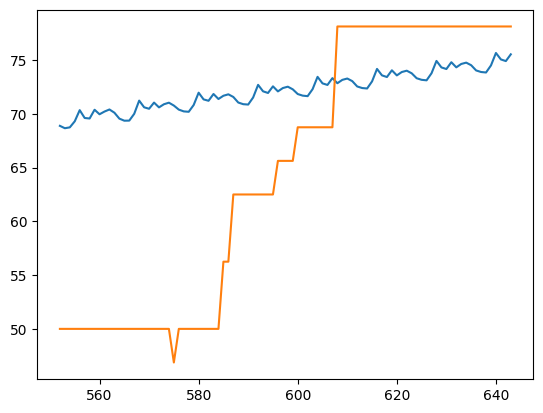

In [17]:
sarima_pred.plot()
test_data['y'].plot()

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE and MAE for Random Forest predictions
sarima_mse = mean_squared_error(test_data[test_data['Mask'] == 1]['y'], sarima_pred)
sarima_mae = mean_absolute_error(test_data[test_data['Mask'] == 1]['y'], sarima_pred)

print(f"Random Forest - Mean Squared Error (MSE): {sarima_mse}")
print(f"Random Forest - Mean Absolute Error (MAE): {sarima_mae}")

Random Forest - Mean Squared Error (MSE): 173.81744925717138
Random Forest - Mean Absolute Error (MAE): 10.82584845531465


In [19]:
from prophet import Prophet
#######################################
# Prophet Model
#######################################
prophet_model = Prophet()
prophet_model.fit(train_data[['ds', 'y']].rename(columns={'ds': 'ds', 'y': 'y'}))
future = prophet_model.make_future_dataframe(periods=len(test_data))
prophet_forecast = prophet_model.predict(future)
prophet_pred = prophet_forecast['yhat'][-len(test_data):]

Importing plotly failed. Interactive plots will not work.
11:23:25 - cmdstanpy - INFO - Chain [1] start processing
11:23:26 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
prophet_pred

552    67.142083
553    68.009986
554    69.320962
555    70.003762
556    71.205815
         ...    
639    76.298936
640    77.550862
641    78.587263
642    79.205779
643    79.882814
Name: yhat, Length: 92, dtype: float64

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE and MAE for Random Forest predictions
prophet_mse = mean_squared_error(test_data[test_data['Mask'] == 1]['y'], prophet_pred)
prophet_mae = mean_absolute_error(test_data[test_data['Mask'] == 1]['y'], prophet_pred)

print(f"Prophet - Mean Squared Error (MSE): {prophet_mse}")
print(f"Prophet - Mean Absolute Error (MAE): {prophet_mae}")


Prophet - Mean Squared Error (MSE): 236.99425008937064
Prophet - Mean Absolute Error (MAE): 11.588769612153738


<Axes: >

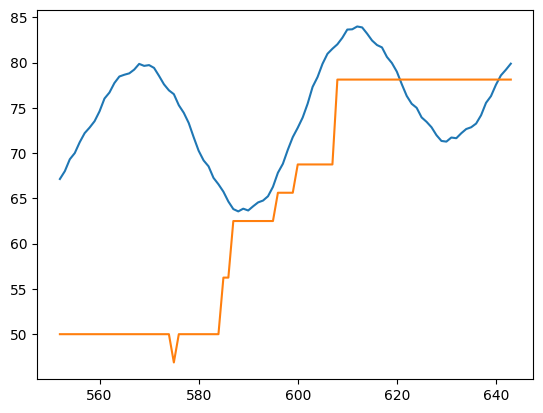

In [22]:
prophet_pred.plot()
test_data['y'].plot()

In [11]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Function to create lagged features
def create_lagged_features(data, max_lag):
    for lag in range(1, max_lag + 1):
        data[f'y_lag{lag}'] = data['y'].shift(lag)
    # Do not drop NaN values to preserve data length, but apply mask later
    return data

# Function to find optimal lags
def find_best_lags(model, train_data, val_data, features, max_lag):
    best_lags, best_mse = 0, float('inf')
    for num_lags in range(1, max_lag + 1):
        lag_features = features[:num_lags]
        model.fit(train_data[lag_features], train_data['y'])
        val_predictions = model.predict(val_data[lag_features])
        mse = mean_squared_error(val_data['y'], val_predictions)
        if mse < best_mse:
            best_mse, best_lags = mse, num_lags
    return best_lags, best_mse

# Split data into training and testing sets
train_data = available_data[available_data['ds'] < '2024-09-15']
test_data = available_data[available_data['ds'] >= '2024-09-15']

# Generate lagged features without dropping NaNs
max_lag = 60
train_data = create_lagged_features(train_data, max_lag)
test_data = create_lagged_features(test_data, max_lag)

# Split training data into train and validation subsets
train_subset = train_data[train_data['ds'] < '2023-09-15']
# Ensure validation set does not include data that will be in the test set
val_subset = train_data[(train_data['ds'] >= '2023-09-15') & (train_data['ds'] < '2024-09-15')]


# Define features
features = [f'y_lag{i}' for i in range(1, max_lag + 1)]

# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
best_lags_rf, best_mse_rf = find_best_lags(rf_model, train_subset, val_subset, features, max_lag)

# Train final RF model
final_rf_features = features[:best_lags_rf]
rf_model.fit(train_data[final_rf_features], train_data['y'])
rf_predictions = rf_model.predict(test_data[final_rf_features])

# XGBoost Model with scaling
scaler = StandardScaler()
train_data['y_scaled'] = scaler.fit_transform(train_data[['y']])
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
best_lags_xgb, best_mse_xgb = find_best_lags(xgb_model, train_subset, val_subset, features, max_lag)

# Train final XGBoost model
final_xgb_features = features[:best_lags_xgb]
xgb_model.fit(train_data[final_xgb_features], train_data['y_scaled'])
xgb_predictions_scaled = xgb_model.predict(test_data[final_xgb_features])
xgb_predictions = scaler.inverse_transform(xgb_predictions_scaled.reshape(-1, 1))

# Ensure predictions and test_data are aligned and of the same length
rf_pred_aligned = rf_predictions[:len(test_data)]
xgb_pred_aligned = xgb_predictions[:len(test_data)]

# Apply mask to exclude missing data (Mask == 0)
if 'Mask' in test_data.columns:
    rf_pred_aligned = rf_pred_aligned[test_data['Mask'] == 1]
    xgb_pred_aligned = xgb_pred_aligned[test_data['Mask'] == 1]


C:\Windows\Temp\ipykernel_17880\487008908.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'y_lag{lag}'] = data['y'].shift(lag)
C:\Windows\Temp\ipykernel_17880\487008908.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'y_lag{lag}'] = data['y'].shift(lag)
C:\Windows\Temp\ipykernel_17880\487008908.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [24]:
rf_pred_aligned

array([45.65136427, 50.6205832 , 50.6205832 , 50.6205832 , 50.6205832 ,
       50.6205832 , 50.6205832 , 50.6205832 , 50.6205832 , 50.6205832 ,
       50.6205832 , 50.6205832 , 50.6205832 , 50.6205832 , 50.6205832 ,
       50.6205832 , 50.6205832 , 50.6205832 , 50.6205832 , 50.6205832 ,
       50.6205832 , 50.6205832 , 50.6205832 , 50.6205832 , 47.66881873,
       50.6205832 , 50.6205832 , 50.6205832 , 50.6205832 , 50.6205832 ,
       50.6205832 , 50.6205832 , 50.6205832 , 50.6205832 , 54.98490641,
       54.98490641, 61.27141553, 61.27141553, 61.27141553, 61.27141553,
       61.27141553, 61.27141553, 61.27141553, 61.27141553, 61.27141553,
       61.27141553, 61.27141553, 61.27141553, 61.27141553, 69.60839535,
       69.60839535, 69.60839535, 69.60839535, 69.60839535, 69.60839535,
       69.60839535, 69.60839535, 74.14787033, 74.14787033, 74.14787033,
       74.14787033, 74.14787033, 74.14787033, 74.14787033, 74.14787033,
       74.14787033, 74.14787033, 74.14787033, 74.14787033, 74.14

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE and MAE for Random Forest predictions
rf_mse = mean_squared_error(test_data[test_data['Mask'] == 1]['y'], rf_pred_aligned)
rf_mae = mean_absolute_error(test_data[test_data['Mask'] == 1]['y'], rf_pred_aligned)

print(f"Random Forest - Mean Squared Error (MSE): {rf_mse}")
print(f"Random Forest - Mean Absolute Error (MAE): {rf_mae}")


Random Forest - Mean Squared Error (MSE): 9.94369572746419
Random Forest - Mean Absolute Error (MAE): 2.520641400354224


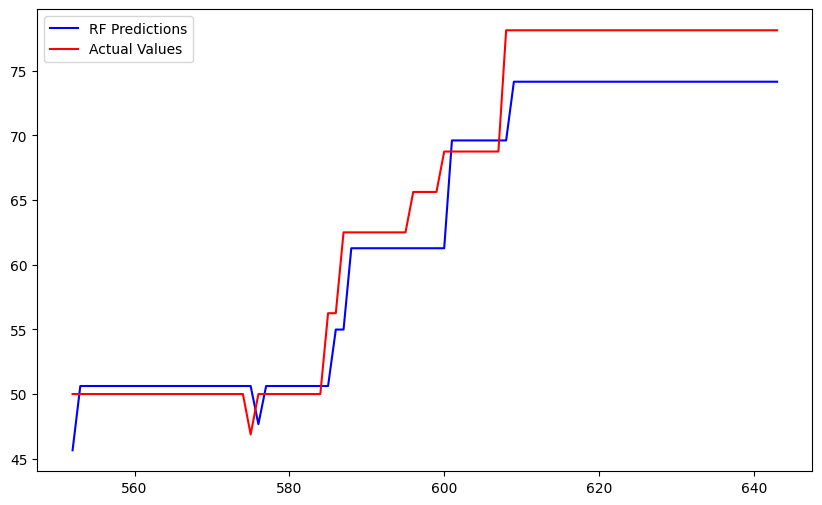

In [26]:
import matplotlib.pyplot as plt

# Convert rf_pred_aligned to a Pandas Series with the same index as test_data
rf_pred_series = pd.Series(rf_pred_aligned, index=test_data.index)

# Plot the predictions and actual values
plt.figure(figsize=(10, 6))
rf_pred_series.plot(label='RF Predictions', color='blue')
test_data['y'].plot(label='Actual Values', color='red')
plt.legend()
plt.show()


In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Calculate MSE and MAE for LSTM predictions
xgb_mse = mean_squared_error(test_data[test_data['Mask'] == 1]['y'], xgb_pred_aligned)
xgb_mae = mean_absolute_error(test_data[test_data['Mask'] == 1]['y'], xgb_pred_aligned)

print(f"XGB - Mean Squared Error (MSE): {xgb_mse}")
print(f"XGB - Mean Absolute Error (MAE): {xgb_mae}")

XGB - Mean Squared Error (MSE): 9.688699960621623
XGB - Mean Absolute Error (MAE): 2.476131522137186


In [28]:
xgb_pred_aligned

array([[46.87508 ],
       [50.567654],
       [50.567654],
       [50.567654],
       [50.567654],
       [50.567654],
       [50.567654],
       [50.567654],
       [50.567654],
       [50.567654],
       [50.567654],
       [50.567654],
       [50.567654],
       [50.567654],
       [50.567654],
       [50.567654],
       [50.567654],
       [50.567654],
       [50.567654],
       [50.567654],
       [50.567654],
       [50.567654],
       [50.567654],
       [50.567654],
       [47.6137  ],
       [50.567654],
       [50.567654],
       [50.567654],
       [50.567654],
       [50.567654],
       [50.567654],
       [50.567654],
       [50.567654],
       [50.567654],
       [55.09246 ],
       [55.09246 ],
       [61.36269 ],
       [61.36269 ],
       [61.36269 ],
       [61.36269 ],
       [61.36269 ],
       [61.36269 ],
       [61.36269 ],
       [61.36269 ],
       [61.36269 ],
       [61.36269 ],
       [61.36269 ],
       [61.36269 ],
       [61.36269 ],
       [69.71063 ],


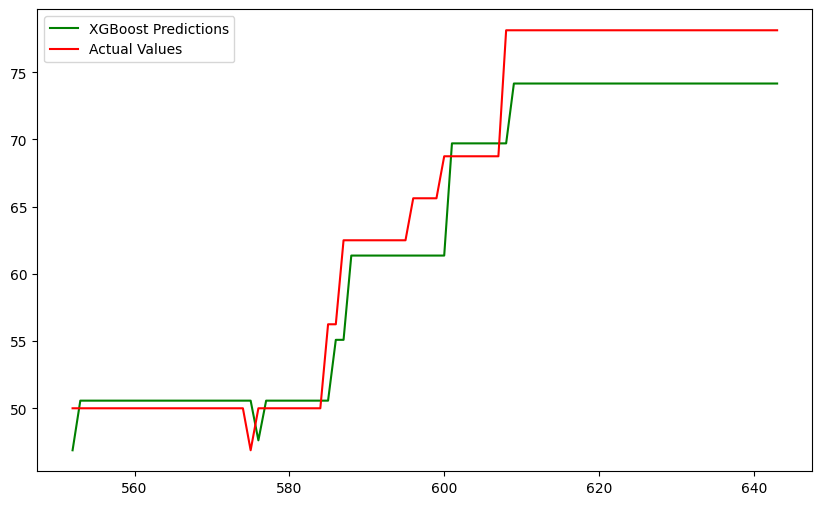

In [29]:
import matplotlib.pyplot as plt

# Convert xgb_pred_aligned to a 1-dimensional array and then to a Pandas Series with the same index as test_data
xgb_pred_series = pd.Series(xgb_pred_aligned.ravel(), index=test_data.index)

# Plot the predictions and actual values
plt.figure(figsize=(10, 6))
xgb_pred_series.plot(label='XGBoost Predictions', color='green')
test_data['y'].plot(label='Actual Values', color='red')
plt.legend()
plt.show()


In [12]:
# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [32]:
from sklearn.preprocessing import MinMaxScaler
# Define function to reverse scaling (to original range)
def reverse_scaling(predictions, data):
    return predictions * (data['y'].max() - data['y'].min()) + data['y'].min()

# Split the data into train and test (after defining 'Mask')
train_data = data[data['ds'] < '2024-09-15']
test_data = data[data['ds'] >= '2024-09-15']

# Apply MinMax scaling only on the training data
scaler = MinMaxScaler()
train_scaled = train_data[['y']]
train_scaled['y'] = scaler.fit_transform(train_scaled)

# Apply the same scaler to the test data (to avoid leakage)
test_scaled = test_data[['y']]
test_scaled['y'] = scaler.transform(test_scaled)

# Evaluate different sequence lengths (lags)
lags = [1, 2, 3, 5, 10, 15, 20, 30, 35, 40, 45, 50]  # List of lags to try
best_mse = float('inf')  # Initialize best MSE as a large number
best_seq_length = None
best_lstm_pred = None

# ONLY create sequences using train data and then test the model on the test data
for seq_length in lags:
    # Create sequences ONLY using training data
    X_train, y_train = create_sequences(train_scaled['y'].values, seq_length)
    X_test, y_test = create_sequences(test_scaled['y'].values, seq_length)

    # Reshape input for LSTM: [samples, time steps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build LSTM model
    lstm_model = Sequential([
        LSTM(100, activation='relu', input_shape=(seq_length, 1)),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')

    # Train the LSTM model
    lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Make predictions
    lstm_pred = lstm_model.predict(X_test)

    # Reverse scaling to get predictions back to original values
    lstm_pred = reverse_scaling(lstm_pred, data)

    # Calculate MSE for the current sequence length
    mse = mean_squared_error(y_test, lstm_pred)

    # Update best MSE and best sequence length
    if mse < best_mse:
        best_mse = mse
        best_seq_length = seq_length
        best_lstm_pred = lstm_pred

# Print the best sequence length and its MSE
print(f"Best Sequence Length (Lag): {best_seq_length}")
print(f"Best MSE: {best_mse}")


C:\Windows\Temp\ipykernel_18288\413316236.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_scaled['y'] = scaler.fit_transform(train_scaled)
C:\Windows\Temp\ipykernel_18288\413316236.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_scaled['y'] = scaler.transform(test_scaled)
c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001631008E0E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Best Sequence Length (Lag): 5
Best MSE: 4146.437798743495


In [33]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].clone().detach(), self.y[idx].clone().detach()
    
# Transformer Model
# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, ff_dim, num_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.transformer_blocks = nn.ModuleList([
            nn.TransformerEncoderLayer(embed_dim, num_heads, ff_dim) for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(embed_dim, 1)

    def forward(self, x):
        x = self.embedding(x)  # Shape: (batch_size, seq_length, embed_dim)
        for transformer in self.transformer_blocks:
            x = transformer(x)
        return self.fc_out(x[:, -1, :])  # Output only the last time step

In [13]:
from sklearn.preprocessing import MinMaxScaler

# Split the data into train, validation, and test
train_data = data[data['ds'] < '2023-09-15']
val_data = data[(data['ds'] >= '2023-09-15') & (data['ds'] < '2024-09-15')]
test_data = data[data['ds'] >= '2024-09-15']

# Apply MinMax scaling only on the training data
scaler = MinMaxScaler()
train_scaled = train_data[['y']].copy()
train_scaled['y'] = scaler.fit_transform(train_scaled)

# Apply the same scaler to validation and test data (to avoid data leakage)
val_scaled = val_data[['y']].copy()
val_scaled['y'] = scaler.transform(val_scaled)

test_scaled = test_data[['y']].copy()
test_scaled['y'] = scaler.transform(test_scaled)


In [15]:
# Final model with the best sequence length
best_seq_length = 5
X_train, y_train = create_sequences(train_scaled['y'].values, best_seq_length)
X_val, y_val = create_sequences(val_scaled['y'].values, best_seq_length)
X_test, y_test = create_sequences(test_scaled['y'].values, best_seq_length)

# Reshape input for LSTM: [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [16]:
# Define and compile the LSTM model
lstm_model = Sequential([
    LSTM(100, activation='relu', input_shape=(best_seq_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train the LSTM model with validation data
lstm_model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_val, y_val),  # Include validation data
    verbose=1
)


c:\Users\Aqib Gul\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0994 - val_loss: 0.0138
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0062 - val_loss: 0.0076
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0048 - val_loss: 0.0071
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0050 - val_loss: 0.0062
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0056 - val_loss: 0.0059
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0062 - val_loss: 0.0059
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0039 - val_loss: 0.0059
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0044 - val_loss: 0.0050
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0045 - val_loss: 0.0053
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0080 - val_loss: 0.0048
Epoch 12/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


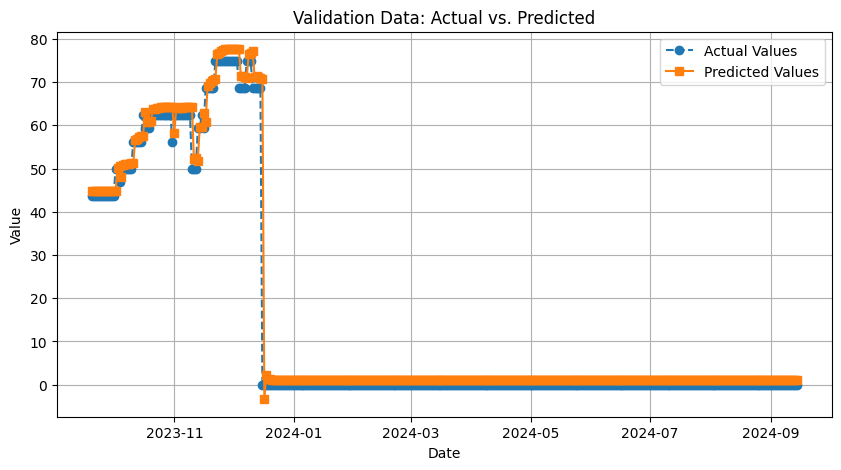

In [21]:
import matplotlib.pyplot as plt

# Predict on validation data
y_val_pred = lstm_model.predict(X_val)

# Inverse transform predictions and actual values to original scale
y_val_pred_inv = scaler.inverse_transform(y_val_pred)
y_val_actual_inv = scaler.inverse_transform(y_val.reshape(-1, 1))

# Align the validation dates (skip the first 'best_seq_length' dates)
aligned_dates = val_data['ds'].iloc[best_seq_length:].values

# Plot actual vs. predicted values
plt.figure(figsize=(10, 5))
plt.plot(aligned_dates, y_val_actual_inv, label="Actual Values", marker='o', linestyle='dashed')
plt.plot(aligned_dates, y_val_pred_inv, label="Predicted Values", marker='s', linestyle='solid')

plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Validation Data: Actual vs. Predicted")
plt.legend()
plt.grid(True)
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


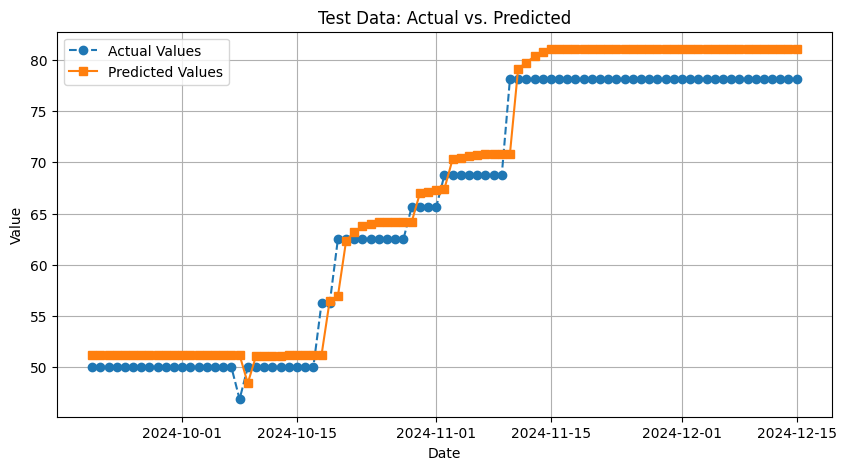

In [22]:
# Predict on test data
y_test_pred = lstm_model.predict(X_test)

# Inverse transform predictions and actual values to the original scale
y_test_pred_inv = scaler.inverse_transform(y_test_pred)
y_test_actual_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Align the test dates (skip the first 'best_seq_length' dates)
aligned_test_dates = test_data['ds'].iloc[best_seq_length:].values

# Plot actual vs. predicted values for test data
plt.figure(figsize=(10, 5))
plt.plot(aligned_test_dates, y_test_actual_inv, label="Actual Values", marker='o', linestyle='dashed')
plt.plot(aligned_test_dates, y_test_pred_inv, label="Predicted Values", marker='s', linestyle='solid')

plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Test Data: Actual vs. Predicted")
plt.legend()
plt.grid(True)
plt.show()


In [37]:
# Make predictions on the test data
lstm_pred = lstm_model.predict(X_test)
# Apply reverse scaling to get the predictions back to the original range
lstm_pred = reverse_scaling(lstm_pred, data)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


In [38]:
lstm_pred_aligned = lstm_pred[test_data['Mask'].iloc[:len(lstm_pred)] == 1]

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE and MAE for Random Forest predictions
lstm_mse = mean_squared_error(test_data[test_data['Mask'] == 1]['y'][5:], lstm_pred_aligned)
lstm_mae = mean_absolute_error(test_data[test_data['Mask'] == 1]['y'][5:], lstm_pred_aligned)

print(f"LSTM - Mean Squared Error (MSE): {lstm_mse}")
print(f"LSTM - Mean Absolute Error (MAE): {lstm_mae}")

LSTM - Mean Squared Error (MSE): 2.347705549789874
LSTM - Mean Absolute Error (MAE): 0.8923045712812193


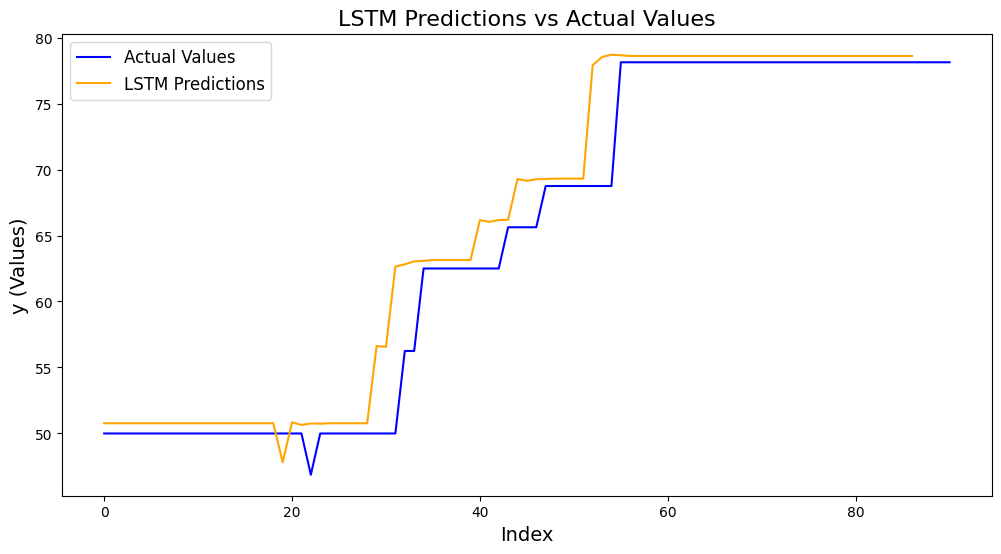

In [42]:
# Extract actual and predicted values for comparison
actual_values = test_data[test_data['Mask'] == 1]['y'][1:]
predicted_values = lstm_pred_aligned

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual_values.values, label="Actual Values", color='blue')
plt.plot(predicted_values, label="LSTM Predictions", color='orange')

# Add title, labels, and legend
plt.title("LSTM Predictions vs Actual Values", fontsize=16)
plt.xlabel("Index", fontsize=14)
plt.ylabel("y (Values)", fontsize=14)
plt.legend(fontsize=12)

In [43]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        # Convert numpy arrays to PyTorch tensors
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [44]:
best_seq_length = 5
# Final model with the best sequence length
X_train, y_train = create_sequences(train_scaled['y'].values, best_seq_length)
X_test, y_test = create_sequences(test_scaled['y'].values, best_seq_length)

train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define and train the final Transformer model
transformer = TransformerModel(input_dim=1, embed_dim=16, num_heads=2, ff_dim=64, num_layers=2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001)
for epoch in range(100):
    transformer.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = transformer(batch_X.unsqueeze(-1))
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
# Make predictions on the test data
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
transformer_pred = transformer(X_test_tensor).detach().numpy()
# Reverse scaling for final predictions
transformer_pred = reverse_scaling(transformer_pred, data)

In [45]:
transformer_pred[test_data['Mask'].iloc[:len(transformer_pred)] == 1].size

87

In [46]:
transformer_pred_aligned = transformer_pred[test_data['Mask'].iloc[:len(transformer_pred)] == 1]

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Align the test data by excluding the first data point
aligned_test_data = test_data[test_data['Mask'] == 1].iloc[5:]  # Skip the first data point

# Calculate MSE and MAE for LSTM predictions
transformer_mse = mean_squared_error(aligned_test_data['y'], transformer_pred_aligned)
transformer_mae = mean_absolute_error(aligned_test_data['y'], transformer_pred_aligned)

print(f"Transformer - Mean Squared Error (MSE): {transformer_mse}")
print(f"Transformer - Mean Absolute Error (MAE): {transformer_mae}")


Transformer - Mean Squared Error (MSE): 17.9572101449574
Transformer - Mean Absolute Error (MAE): 3.5321484437619133


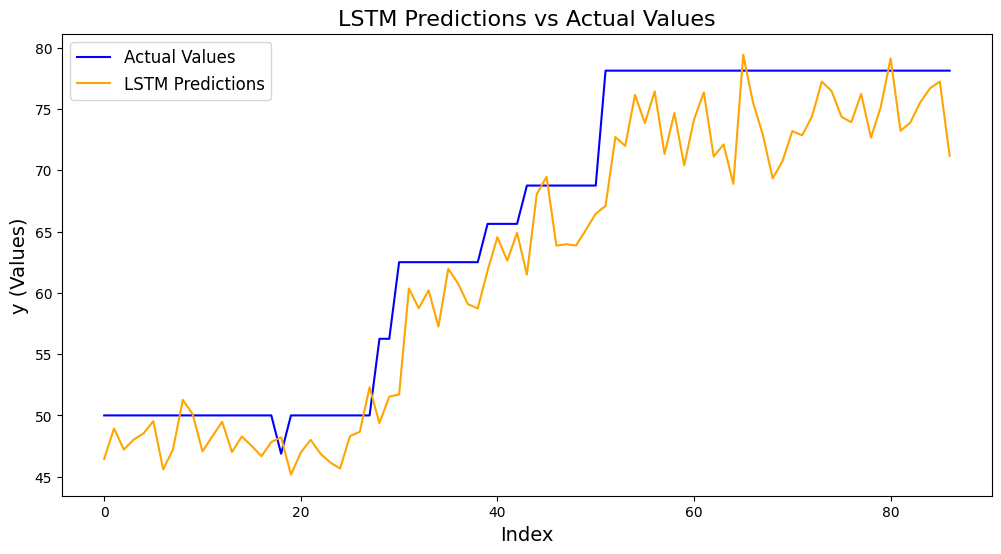

In [50]:
# Extract actual and predicted values for comparison
actual_values = test_data[test_data['Mask'] == 1]['y'][5:]
predicted_values = transformer_pred_aligned
# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual_values.values, label="Actual Values", color='blue')
plt.plot(predicted_values, label="LSTM Predictions", color='orange')
# Add title, labels, and legend
plt.title("LSTM Predictions vs Actual Values", fontsize=16)
plt.xlabel("Index", fontsize=14)
plt.ylabel("y (Values)", fontsize=14)
plt.legend(fontsize=12)

In [51]:
# Create a comparison DataFrame
model_comparison = pd.DataFrame({
    'Model': ['SARIMA', 'Prophet', 'Random Forest', 'XGBoost', 'LSTM', 'Transformer'],
    'MSE': [sarima_mse, prophet_mse, rf_mse, xgb_mse, lstm_mse, transformer_mse],
    'MAE': [sarima_mae, prophet_mae, rf_mae, xgb_mae, lstm_mae, transformer_mae]
})

# Sort models by MSE and MAE
model_comparison_sorted = model_comparison.sort_values(by='MSE')

print(model_comparison_sorted)

           Model         MSE        MAE
4           LSTM    2.347706   0.892305
3        XGBoost    9.688700   2.476132
2  Random Forest    9.943696   2.520641
5    Transformer   17.957210   3.532148
0         SARIMA  173.817449  10.825848
1        Prophet  236.994250  11.588770


C:\Windows\Temp\ipykernel_18288\809461196.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_comparison_sorted, x='Model', y='MSE', palette='viridis')


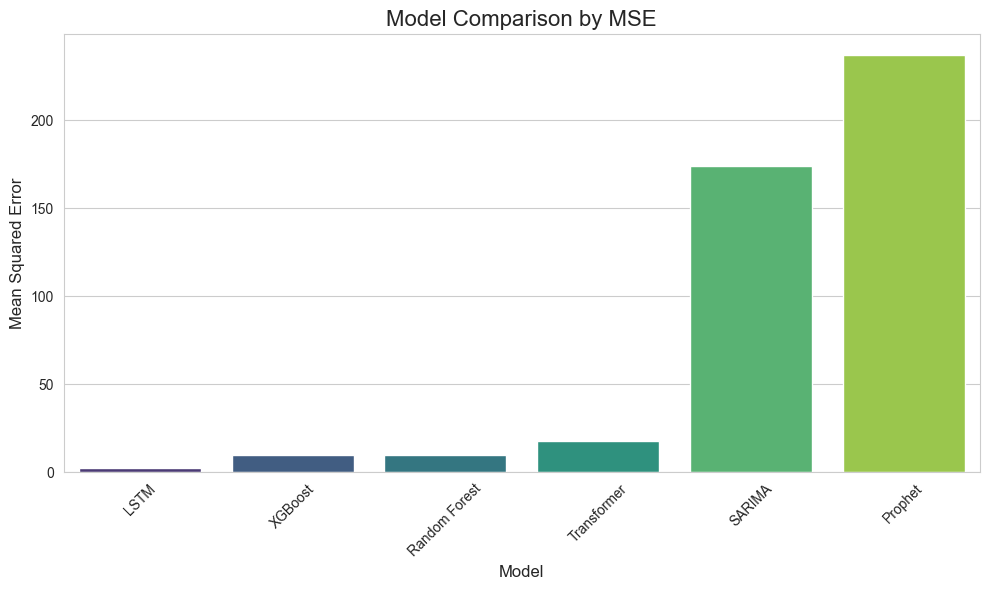

C:\Windows\Temp\ipykernel_18288\809461196.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_comparison_sorted, x='Model', y='MAE', palette='coolwarm')


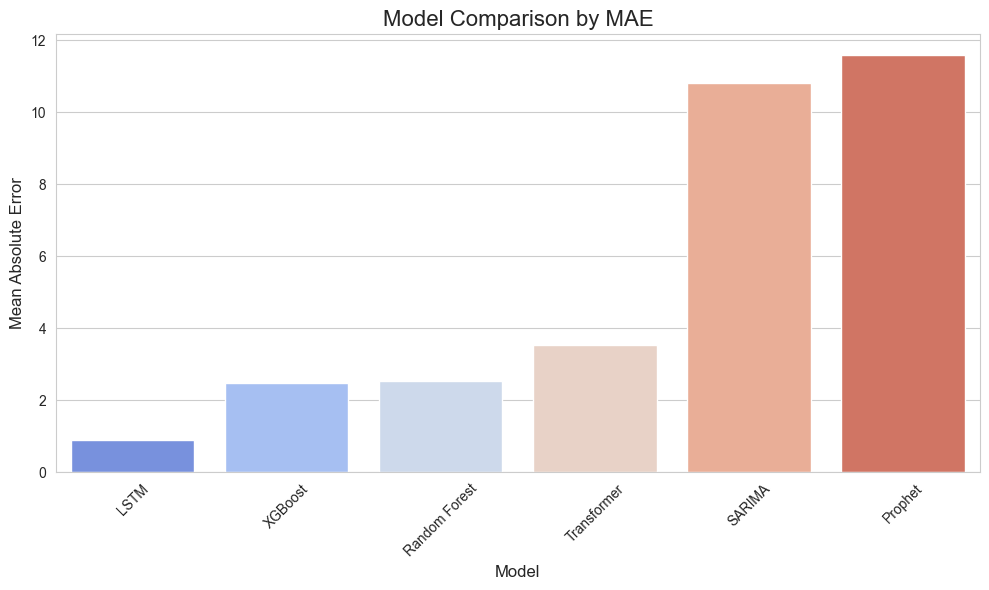

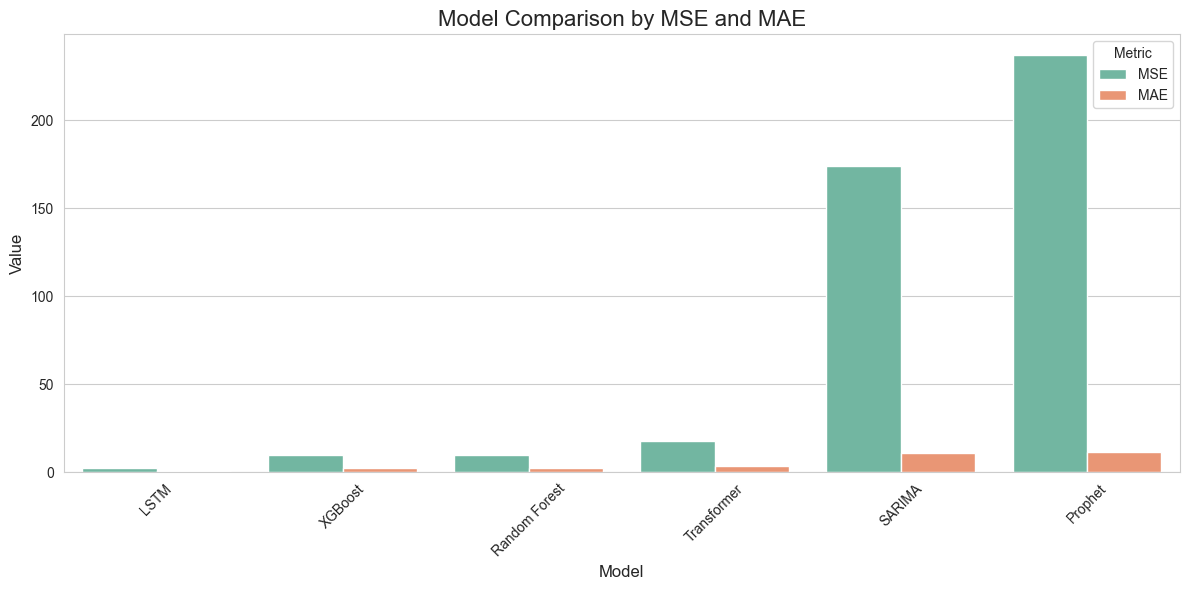

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_style('whitegrid')

# Plot MSE for each model
plt.figure(figsize=(10, 6))
sns.barplot(data=model_comparison_sorted, x='Model', y='MSE', palette='viridis')
plt.title('Model Comparison by MSE', fontsize=16)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot MAE for each model
plt.figure(figsize=(10, 6))
sns.barplot(data=model_comparison_sorted, x='Model', y='MAE', palette='coolwarm')
plt.title('Model Comparison by MAE', fontsize=16)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot MSE and MAE together as a grouped bar plot
melted_comparison = model_comparison_sorted.melt(id_vars='Model', var_name='Metric', value_name='Value')
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_comparison, x='Model', y='Value', hue='Metric', palette='Set2')
plt.title('Model Comparison by MSE and MAE', fontsize=16)
plt.ylabel('Value', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.legend(title='Metric', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


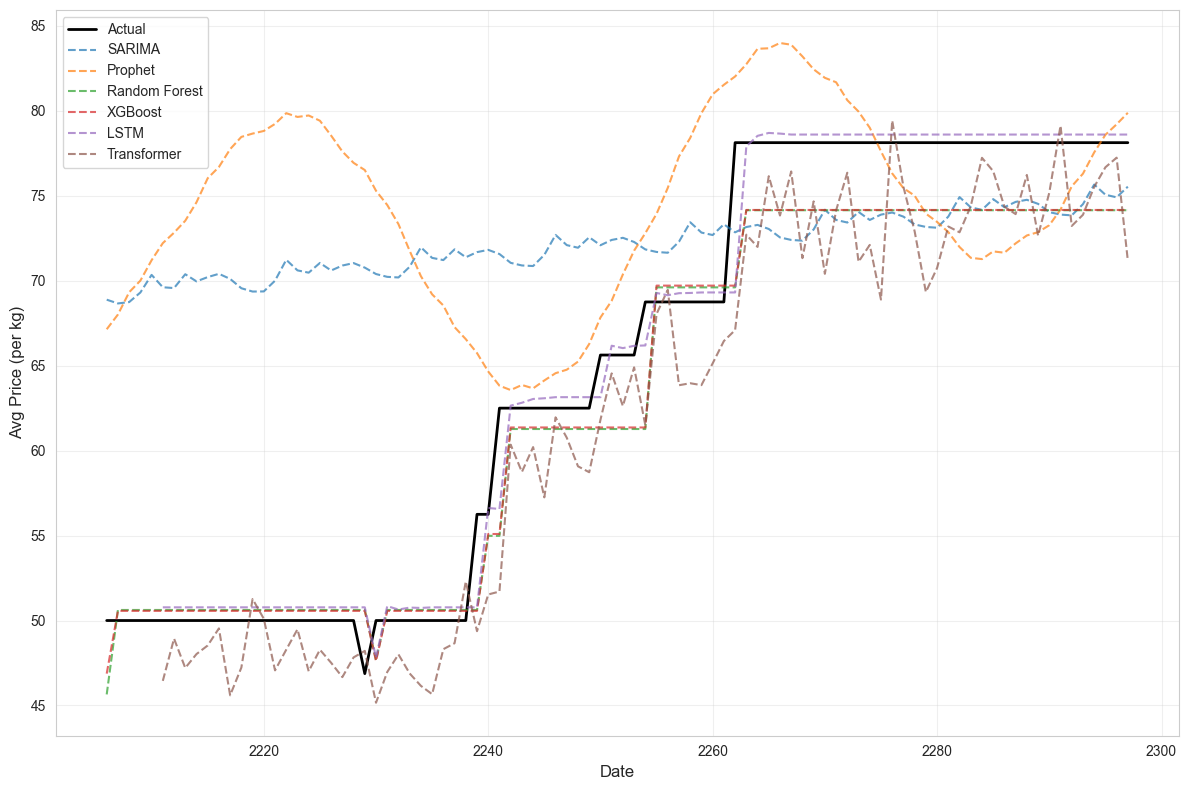

In [54]:
import matplotlib.pyplot as plt

# Actual test values for Mask=1
actual_values = test_data['y'][test_data['Mask'] == 1]

# Plot predictions for each model
plt.figure(figsize=(12, 8))

plt.plot(actual_values.index, actual_values, label='Actual', color='black', linewidth=2)

# Add model predictions
plt.plot(actual_values.index, sarima_pred, label='SARIMA', linestyle='--', alpha=0.7)
plt.plot(actual_values.index, prophet_pred, label='Prophet', linestyle='--', alpha=0.7)
plt.plot(actual_values.index, rf_pred_aligned, label='Random Forest', linestyle='--', alpha=0.7)
plt.plot(actual_values.index, xgb_pred_aligned, label='XGBoost', linestyle='--', alpha=0.7)
plt.plot(actual_values.index[5:], lstm_pred_aligned, label='LSTM', linestyle='--', alpha=0.7)
plt.plot(actual_values.index[5:], transformer_pred_aligned, label='Transformer', linestyle='--', alpha=0.7)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Avg Price (per kg)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()


In [6]:
from keras.models import load_model
from keras.metrics import MeanSquaredError

# Define the custom object for the metric
custom_objects = {'mse': MeanSquaredError()}

# Load the model
model = load_model(r'D:\ML Repositories\Price_forecasting_project\models\lstm_American_grade_B.h5', custom_objects=custom_objects)

# Get the input shape
input_shape = model.input_shape
print(f"Input Shape: {input_shape}")


Input Shape: (None, 21, 1)


In [ ]:
model.save('model_without_metrics.h5', include_optimizer=False)

In [2]:
import pandas as pd
data = pd.read_csv(r'D:\ML Repositories\Price_forecasting_project\data\raw\processed\Narwal\Condition_dataset.csv')

In [4]:
data['Avg Price (per kg)']

0       25.0
1       25.0
2       25.0
3       25.0
4       25.0
        ... 
1884    34.0
1885    34.0
1886    34.0
1887    30.0
1888    30.0
Name: Avg Price (per kg), Length: 1889, dtype: float64